In [2]:
!pip install nltk

  Using cached https://files.pythonhosted.org/packages/c5/10/369f50bcd4621b263927b0a1519987a04383d4a98fb10438042ad410cf88/singledispatch-3.4.0.3-py2.py3-none-any.whl


In [3]:
import pandas as pd
import numpy as np
import nltk

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aditya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aditya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Aditya\AppData\Roaming\nltk_data...


True

In [5]:
!pip install wordcloud

In [6]:
imdb = pd.read_csv('https://raw.githubusercontent.com/skathirmani/datasets/master/imdb_sentiment.csv')

In [7]:
imdb.head()

,review,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [8]:
imdb['sentiment'].value_counts()

1    386
0    362
Name: sentiment, dtype: int64

Bag of Words Analysis
-----------------

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

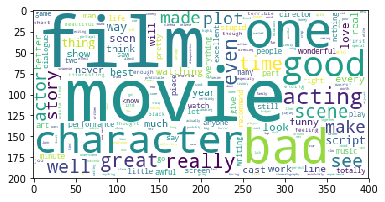

In [10]:
input_string = ' '.join(imdb['review'])
wc = WordCloud(background_color = 'white').generate(input_string)
plt.imshow(wc)

## Text Cleaning
- Convert every character to lower case
- Remove junk characters
- Remove commonly used words
- Identify root of the words

In [11]:
docs = imdb['review'].str.lower().str.replace('[^a-z ]','')

In [12]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)
#stopwords[:5]

179

In [13]:
stemmer = nltk.stem.PorterStemmer()
stemmer.stem('organization')

'organ'

In [14]:
docs_clean = []
for doc in docs.head(2):
    words = doc.split(' ')
    #print(doc)
    #print(words)
    word_clean = []
    for word in words:
        if word not in stopwords:
            word_clean.append(stemmer.stem(word))
    doc_clean = ' '.join(word_clean)
    docs_clean.append(doc_clean)
print(docs_clean)

['slowmov aimless movi distress drift young man  ', 'sure lost  flat charact audienc nearli half walk  ']


In [15]:
docs = imdb['review'].str.lower().str.replace('[^a-z ]','')

def clean_sentence(text):
    words = text.split(' ')
    words_clean = [stemmer.stem(word) for word in words if word not in stopwords]
    return ' '.join(words_clean)
docs_clean = docs.apply(clean_sentence)
docs_clean.head()

0      slowmov aimless movi distress drift young man  
1    sure lost  flat charact audienc nearli half wa...
2    attempt arti black  white clever camera angl m...
3                            littl music anyth speak  
4    best scene movi gerardo tri find song keep run...
Name: review, dtype: object

Sparsity = No. of zeroes / ( No. of Rows * No. of Columns)
------

## Document Term Matrix

In [17]:
!pip install sklearn

  Using cached https://files.pythonhosted.org/packages/c1/1c/8fa5aefe23a2fc254e9faadc10a30052c63d92f05fb59127ff0e65e4171c/scikit_learn-0.20.2-cp36-cp36m-win_amd64.whl


In [18]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(docs_clean)
dtm = vectorizer.transform(docs_clean)
dtm

<748x2475 sparse matrix of type '<class 'numpy.int64'>'
	with 6797 stored elements in Compressed Sparse Row format>

In [19]:
docs_clean.shape

(748,)

In [20]:
no_of_zeroes = (748*2475) - 6797
sparsity = no_of_zeroes / (748*2475) * 100
sparsity

99.63285259007183

In [21]:
df_dtm = pd.DataFrame(dtm.toarray(),
                     columns = vectorizer.get_feature_names())
df_dtm.head()

,aailiyah,abandon,abil,abroad,absolut,abstrus,abysm,academi,accent,access,...,younger,your,youth,youtub,youv,yun,zillion,zombi,zombiestud,zombiez
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
(df_dtm == 0).sum().sum()

1844503

In [23]:
df_dtm.sum().sort_values(ascending=False).head(2)

movi    207
film    184
dtype: int64

In [24]:
df_dtm.sum(axis=1).sort_values(ascending=False).head(10)

136    686
19     425
646    408
149    131
135    107
422     41
192     37
223     34
271     31
230     29
dtype: int64

In [25]:
from sklearn.model_selection import train_test_split
train_x, test_x = train_test_split(df_dtm,
                                  test_size = 0.2,
                                  random_state = 100)

In [26]:
train_y = imdb.iloc[train_x.index]['sentiment']
test_y = imdb.iloc[test_x.index]['sentiment']

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_model = RandomForestClassifier(random_state = 100, n_estimators = 300)
rf_model.fit(train_x, train_y)
rf_predict_class = rf_model.predict(test_x)
accuracy_score(test_y,rf_predict_class)

0.72

## Classification of Hotstar Tweets

In [28]:
hot_star = pd.read_csv('https://raw.githubusercontent.com/skathirmani/datasets/master/hotstar_tweets.csv')

In [29]:
hot_star.head()

,ID,UserName,Created_Date,Reviews,Lower_Case_Reviews,Sentiment_Manual_BP,Sentiment_Manual,Review_Length,DataSource,Year,Month,Date,Sentiment_Polarity,sentiment_vader
0,1,NaN,8/10/2017,Hh,hh,Negative,Negative,2,Google_PlayStore,2017,8,10,Neutral,Neutral
1,2,NaN,8/11/2017,No,no,Negative,Negative,2,Google_PlayStore,2017,8,11,Neutral,Negative
2,3,asadynwa,8/12/2017,@hotstar_helps during paymnt for premium subsc...,@hotstar_helps during paymnt for premium subsc...,Help,Negative,140,Twitter,2017,8,12,Negative,Negative
3,4,jineshroxx,8/11/2017,@hotstartweets I am currently on Jio network a...,@hotstartweets i am currently on jio network a...,Help,Negative,140,Twitter,2017,8,11,Positive,Positive
4,5,YaminiSachar,8/5/2017,@hotstartweets the episodes of Sarabhai vs Sar...,@hotstartweets the episodes of sarabhai vs sar...,Help,Negative,140,Twitter,2017,8,5,Neutral,Neutral


In [30]:
hot_star.isnull().sum()

ID                       0
UserName               722
Created_Date             0
Reviews                  0
Lower_Case_Reviews       0
Sentiment_Manual_BP      0
Sentiment_Manual         0
Review_Length            0
DataSource               0
Year                     0
Month                    0
Date                     0
Sentiment_Polarity       0
sentiment_vader          0
dtype: int64

In [31]:
hot_star.shape

(5053, 14)

In [34]:
hot_star['Sentiment_Manual'].value_counts()

Neutral     1738
Positive    1733
Negative    1582
Name: Sentiment_Manual, dtype: int64

## Data Cleaning

In [36]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)
#docs_hotstar= imdb['Reviews'].str.lower().str.replace('[^a-z ]','')

179

In [35]:
docs_hotstar= hot_star['Reviews'].str.lower().str.replace('[^a-z ]','')

In [37]:
stemmer = nltk.stem.PorterStemmer()

In [40]:
docs_clean = []
for doc in docs_hotstar:
    words = doc.split(' ')
    #print(doc)
    #print(words)
    word_clean = []
    for word in words:
        if word not in stopwords:
            word_clean.append(stemmer.stem(word))
    doc_clean = ' '.join(word_clean)
    docs_clean.append(doc_clean)
print(docs_clean[0:5])

['hh', '', 'hotstarhelp paymnt premium subscript transact fail twice receiv refund one transact', 'hotstartweet current jio network would like know whether abl watch epl telecast star sport select hd', 'hotstartweet episod sarabhai vs sarabhai season  download abl watch offlin pleas smthng']


In [41]:
docs = hot_star['Reviews'].str.lower().str.replace('[^a-z ]','')

def clean_sentence(text):
    words = text.split(' ')
    words_clean = [stemmer.stem(word) for word in words if word not in stopwords]
    return ' '.join(words_clean)
docs_clean = docs.apply(clean_sentence)
docs_clean.head()

0                                                   hh
1                                                     
2    hotstarhelp paymnt premium subscript transact ...
3    hotstartweet current jio network would like kn...
4    hotstartweet episod sarabhai vs sarabhai seaso...
Name: Reviews, dtype: object

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(docs_clean)
dtm = vectorizer.transform(docs_clean)
dtm

<5053x6145 sparse matrix of type '<class 'numpy.int64'>'
	with 37273 stored elements in Compressed Sparse Row format>

In [ ]:
no_of_zeroes = (5053*6145) - 37273 
sparsity = no_of_zeroes / (5053*6145) * 100
sparsity

In [43]:
df_dtm = pd.DataFrame(dtm.toarray(),
                     columns = vectorizer.get_feature_names())
df_dtm.head()


,aa,aaaaaand,aaaaah,aab,aabe,aacikelqcgv,aadat,aadhaar,aadhaarmem,aadhitamizhan,...,zeemoham,zeetv,zero,zinab,zindabad,ziuoubngwejxo,zmilap,znmd,zombi,zzzune
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
(df_dtm == 0).sum().sum()

31013412

In [45]:
df_dtm.sum().sort_values(ascending=False).head(2)

hotstartweet    1367
hotstar         1351
dtype: int64

In [46]:
df_dtm.sum(axis=1).sort_values(ascending=False).head(10)

5040    55
5051    50
5052    48
5050    48
5049    45
5044    44
4956    43
5048    43
5045    39
5047    39
dtype: int64

In [47]:
from sklearn.model_selection import train_test_split
train_x, test_x = train_test_split(df_dtm,
                                  test_size = 0.2,
                                  random_state = 100)

In [48]:
train_y = hot_star.iloc[train_x.index]['Sentiment_Manual']
test_y = hot_star.iloc[test_x.index]['Sentiment_Manual']

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_model = RandomForestClassifier(random_state = 100, n_estimators = 300)
rf_model.fit(train_x, train_y)
rf_predict_class = rf_model.predict(test_x)
accuracy_score(test_y,rf_predict_class)

0.7299703264094956

In [52]:
from sklearn.naive_bayes import MultinomialNB
#from sklearn.metrics import accuracy_score
rf_model = MultinomialNB()
rf_model.fit(train_x, train_y)
rf_predict_class = rf_model.predict(test_x)
accuracy_score(test_y,rf_predict_class)

0.7359050445103857

## TF-IDF Vectorizer

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

train,test = train_test_split(docs_clean,test_size=0.2,random_state = 100)

tfidf = TfidfVectorizer()
tfidf.fit(train)

train_dtm_tfidf = tfidf.transform(train)
test_dtm_tfidf = tfidf.transform(test)


df_train_tfidf = pd.DataFrame(train_dtm_tfidf.toarray(),columns=tfidf.get_feature_names())
df_test_tfidf = pd.DataFrame(test_dtm_tfidf.toarray(),columns=tfidf.get_feature_names())

train_y = hot_star.iloc[df_train_tfidf.index]['Sentiment_Manual']
test_y = hot_star.iloc[df_test_tfidf.index]['Sentiment_Manual']

rf_model = RandomForestClassifier(random_state = 100, n_estimators = 300)

rf_model.fit(df_train_tfidf,train_y)
rf_predict_class = rf_model.predict(df_test_tfidf)
accuracy_score(test_y,rf_predict_class)

0.29376854599406527